In [1]:
from circuit_knitting.cutting import partition_problem
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import SparsePauliOp, PauliList
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qiskit_algorithms.optimizers.cobyla import COBYLA
from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit_algorithms.utils import algorithm_globals
from IPython.display import clear_output
from loss_optimization.accuracy_score import encode_y
import time

/tmp/ipykernel_32520/2279893312.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/tmp/ipykernel_32520/2279893312.py:9: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import ADAM, SPSA


In [2]:
seed = 100

## AWS imports

In [3]:
from qiskit_braket_provider import AWSBraketProvider, BraketLocalBackend

In [4]:
aws_provider = AWSBraketProvider()
# backends = aws_provider.backends()

online_sim = aws_provider.get_backend("TN1")
local_sim = BraketLocalBackend()

## Data Loading

In [5]:
# Load data
data = pd.read_csv("diabetes_normalized.csv")
data = data.drop(["Unnamed: 0"], axis=1)
data.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.923998,1.531329,0.566517,-0.920265,-3.141593,0.004682,-1.66872,-0.104720,1
1,-2.771994,-0.457820,0.257508,-1.301064,-3.141593,-0.650792,-2.40918,-2.094395,0


In [6]:
y = data["Outcome"]
x = data.drop(["Outcome"], axis=1)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(537, 8) (537,) (231, 8) (231,)


In [8]:
x_train_A = x_train.iloc[:, :4]
x_train_B = x_train.iloc[:, 4:]

In [9]:
x_test_A = x_test.iloc[:, :4]
x_test_B = x_test.iloc[:, 4:]

In [10]:
new_y_train = encode_y(y_train)
new_y_test = encode_y(y_test)

## Data Embedding

In [11]:
# Data Embedding - Angle Encoding
def angle_encoding(feature_dims: int):
    embedding = QuantumCircuit(feature_dims)
    feature_param = ParameterVector("Theta", feature_dims)
    for qubit in range(feature_dims):
        embedding.ry(feature_param[qubit], qubit)
    return embedding, feature_param

In [12]:
embedding, feature_params = angle_encoding(4)

## Tensor Network

In [13]:
from tensor_network.ttn import TTN

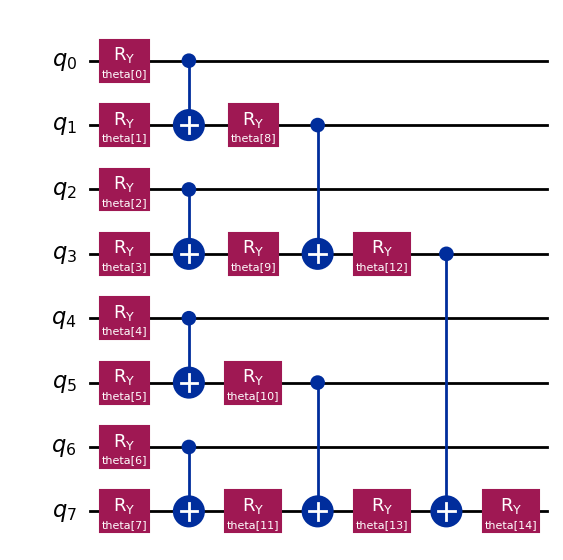

In [14]:
ttn = TTN(num_qubits=8).ttn_simple(complex_structure=False)
ttn.draw("mpl", style="iqp")

In [15]:
# ttn.parameters

## Circuit Cutting

In [16]:
observables = PauliList(["ZIIIIIII"])
partitioned_problem = partition_problem(circuit=ttn, partition_labels="AAAABBBB", observables=observables)
sub_circuits = partitioned_problem.subcircuits
sub_observables = partitioned_problem.subobservables
bases = partitioned_problem.bases

In [17]:
sub_observables

{'A': PauliList(['IIII']), 'B': PauliList(['ZIII'])}

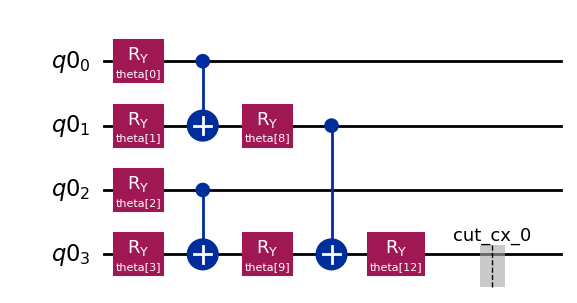

In [18]:
sub_circuits["A"].draw("mpl", style="iqp")

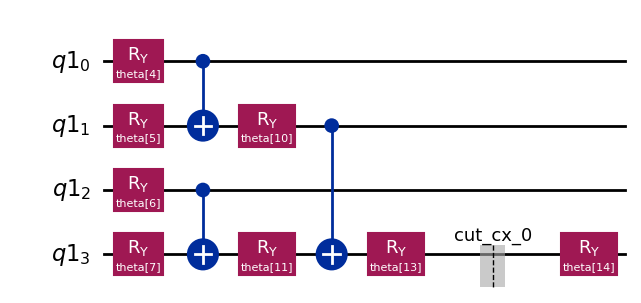

In [19]:
sub_circuits["B"].draw("mpl", style="iqp")

In [20]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 9.0


### Sub Experiments

In [21]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=sub_circuits, observables=sub_observables, num_samples=np.inf
)

In [22]:
# subexperiments
len(subexperiments["A"])

6

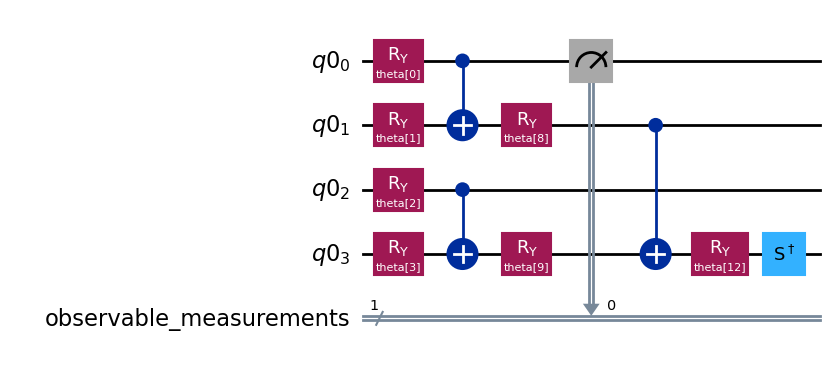

In [23]:
subexperiments["A"][0].draw("mpl", style="iqp")

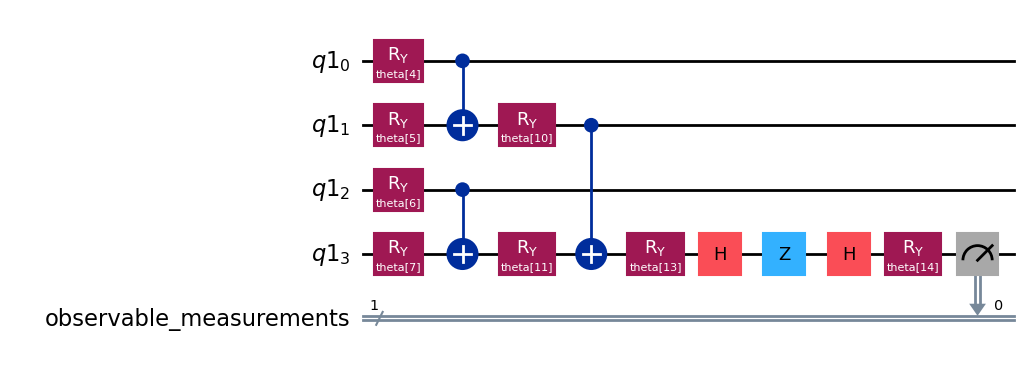

In [24]:
subexperiments["B"][3].draw("mpl", style="iqp")

## Neural Network Training

In [25]:
from qiskit_machine_learning.neural_networks import SamplerQNN, NeuralNetwork
from qiskit_aer.primitives import Sampler
from typing import Callable

In [26]:
# sampler = Sampler(backend_options={"simulator": local_sim}, transpile_options={"optimization_level": 3})
sampler = Sampler(backend_options={"simulator": online_sim})

### Sampler

In [27]:
from primitives.custom_sampler_qnn import CustomSampler

#### For subexperiments["A"]

In [28]:
final_circuits = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["A"]]
# final_circuits[0].draw("mpl")

In [29]:
sampler_qcnn = CustomSampler(
    circuits=final_circuits, 
    sampler=sampler,
    input_params=feature_params.params,
    weight_params=sub_circuits["A"].parameters,
    input_gradients=False,
)

In [30]:
weights_A = algorithm_globals.random.random(7)
forward_output = sampler_qcnn.forward(
    input_data=x_train_A,
    weights=weights_A,
)

Running Time for Forward Pass: %s seconds 6.814657211303711


In [31]:
# forward output is a dictionary of 6 subex_circ items.
print(f"Output shape for {len(x_train_A)} samples: {forward_output[0].shape}")
print(len(forward_output[0]))
print(f"Output of the forward pass for first sample: \n{np.array([forward_output[i][0] for i in range(6)])}")

Output shape for 537 samples: (537, 16)
537
Output of the forward pass for first sample: 
[[0.3046875  0.6953125  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.31054688 0.68945312 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.10351562 0.06835938 0.20117188 0.62695312 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.10351562 0.06738281 0.20605469 0.62304688 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.29785156 0.70214844 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.328125   0.671875   0.         0.         0.         0.
  0.         0.

In [32]:
input_grad, weights_grad = sampler_qcnn.backward(
    input_data=x_train_A,
    weights=weights_A
)

Running Time for Backward Pass: %s seconds 153.4615454673767


In [33]:
print(f"Output shape for {len(x_train_A)} samples: {weights_grad[0].shape}")
print(f"Output of the backward pass for first sample for first subexperiment circuit: \n{np.array([weights_grad[i][0] for i in range(6)])}")

Output shape for 537 samples: (537, 16, 7)
Output of the backward pass for first sample for first subexperiment circuit: 
[[[ 0.953125    0.          0.          0.          0.
    0.          0.        ]
  [-0.953125    0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.      

#### For subexperiments["B"]

In [34]:
final_circuits2 = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["B"]]

In [35]:
sampler_qcnn2 = CustomSampler(
    circuits=final_circuits2, 
    sampler=sampler,
    input_params=feature_params.params,
    weight_params=sub_circuits["B"].parameters,
)

In [36]:
weights_B = algorithm_globals.random.random(8)
forward_output2 = sampler_qcnn2._forward(
    input_data=x_train_B,
    weights=weights_B,
)

Running Time for Forward Pass: %s seconds 24.65860366821289


In [37]:
print(f"Output shape for {len(x_train_A)} samples: {forward_output2[0].shape}")
print(len(forward_output2[0]))
print(f"Output of the forward pass for first sample: \n{np.array([forward_output2[i][0] for i in range(6)])}")

Output shape for 537 samples: (537, 16)
537
Output of the forward pass for first sample: 
[[0.60839844 0.39160156 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.6015625  0.3984375  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.84667969 0.15332031 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.33691406 0.66308594 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.05859375 0.08300781 0.53027344 0.328125   0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.05273438 0.08691406 0.5390625  0.32128906 0.         0.
  0.         0.

In [38]:
input_grad2, weights_grad2 = sampler_qcnn2._backward(
    input_data=x_train_B,
    weights=weights_B
)

Running Time for Backward Pass: %s seconds 587.3339047431946


In [39]:
print(f"Output shape for {len(x_train_B)} samples: {weights_grad2[0].shape}")
print(f"Output of the backward pass for first sample for first subexperiment circuit: \n{np.array([weights_grad2[i][0] for i in range(6)])}")

Output shape for 537 samples: (537, 16, 8)
Output of the backward pass for first sample for first subexperiment circuit: 
[[[ 0.26416016  0.          0.          0.          0.
    0.          0.          0.        ]
  [-0.26416016  0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.     

## Loss and Optimization

In [40]:
from qiskit_machine_learning.utils.loss_functions import L2Loss
from qiskit_algorithms.optimizers import COBYLA, SPSA, GradientDescent
from loss_optimization.objective_func import CustomMultiClassObjectiveFunction
from loss_optimization.custom_cross_entropy_loss import CustomCrossEntropyLoss
# from loss_optimization.callback import callback
from loss_optimization.optimization import create_objective, minimizer, print_optimizer_results

In [41]:
def callback_spsa(nfev=None, params=None, fval=None, stepsize=None, accepted=None):
    """
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    # objective_func_vals = loss
    global objective_func_vals

    if (nfev % 3) == 0:
        objective_func_vals.append(fval)
        print(f"SPSA Epoch {len(objective_func_vals)}: {fval:.5f}")

In [42]:
objective_func_vals = []
# loss = L2Loss()
loss = CustomCrossEntropyLoss()
# optimizer = COBYLA(maxiter=10)
optimizer = SPSA(maxiter=5, callback=callback_spsa)
# optimizer = GradientDescent(maxiter=2) # This doesn't work yet. The gradient shape doesn't match.

#### Optimizer Result for sub-circuits["A"]

In [43]:
initial_point = np.random.random((7,))
function = CustomMultiClassObjectiveFunction(x_train_A, new_y_train, sampler_qcnn, loss)

In [ ]:
# Optimizer result for 0th circuit for sub-circuit-A
start_time = time.time()
optimizer_result_A0 = minimizer(function, function.objective0, function.gradient0, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A1: %s seconds", running_time)

start_time = time.time()
optimizer_result_A1 = minimizer(function, function.objective1, function.gradient1, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A2: %s seconds", running_time)

start_time = time.time()
optimizer_result_A2 = minimizer(function, function.objective2, function.gradient2, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A3: %s seconds", running_time)

start_time = time.time()
optimizer_result_A3 = minimizer(function, function.objective3, function.gradient3, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A4: %s seconds", running_time)

start_time = time.time()
optimizer_result_A4 = minimizer(function, function.objective4, function.gradient4, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A5: %s seconds", running_time)

start_time = time.time()
optimizer_result_A5 = minimizer(function, function.objective5, function.gradient5, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A6: %s seconds", running_time)

Running Time for Forward Pass: %s seconds 6.043295860290527
Running Time for Forward Pass: %s seconds 6.067039728164673
Running Time for Forward Pass: %s seconds 6.251935243606567
Running Time for Forward Pass: %s seconds 6.2559568881988525
Running Time for Forward Pass: %s seconds 6.011391639709473
Running Time for Forward Pass: %s seconds 6.581056356430054
Running Time for Forward Pass: %s seconds 6.392679214477539
Running Time for Forward Pass: %s seconds 5.90235161781311
Running Time for Forward Pass: %s seconds 6.566442251205444
Running Time for Forward Pass: %s seconds 5.9861900806427
Running Time for Forward Pass: %s seconds 6.266240835189819
Running Time for Forward Pass: %s seconds 5.807137489318848
Running Time for Forward Pass: %s seconds 6.12001895904541
Running Time for Forward Pass: %s seconds 6.598379135131836
Running Time for Forward Pass: %s seconds 6.1858179569244385
Running Time for Forward Pass: %s seconds 6.664969205856323
Running Time for Forward Pass: %s seconds 

In [ ]:
optimizer_results_A = [optimizer_result_A0, optimizer_result_A1, optimizer_result_A2, optimizer_result_A3, optimizer_result_A4, optimizer_result_A5]

In [ ]:
# Print results from 6 sub-experiments of sub-circuit-A
for opt_result in optimizer_results_A:
    print_optimizer_results(opt_result)

New params (The final point of the minimization): [ 1.92460819  1.08123869  0.68230983  1.54001489 -0.04515279  0.23760917
  0.78371237]
The final value of the minimization: -7.108707970295499
The final gradient of the minimization: None
The total number of function evaluations: 15
The total number of gradient evaluations: None
The total number of iterations: 5
New params (The final point of the minimization): [ 1.92129285 -0.05937963  1.06766458  0.8896559   1.1701145   0.62219548
  1.17857829]
The final value of the minimization: -7.102378315535572
The final gradient of the minimization: None
The total number of function evaluations: 15
The total number of gradient evaluations: None
The total number of iterations: 5
New params (The final point of the minimization): [ 2.27158872  0.70752877  0.24770143  0.67590738  0.75952765 -0.5494493
  1.30616798]
The final value of the minimization: -5.322093173787746
The final gradient of the minimization: None
The total number of function evalua

Text(0.5, 1.0, 'Training loss')

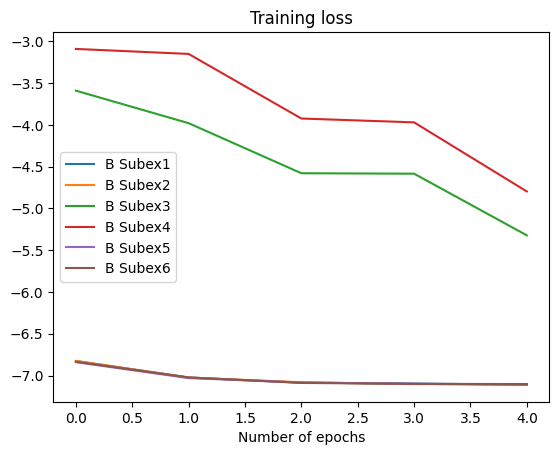

In [ ]:
plt.plot(objective_func_vals[:5], label="B Subex1")
plt.plot(objective_func_vals[5:10], label="B Subex2")
plt.plot(objective_func_vals[10:15], label="B Subex3")
plt.plot(objective_func_vals[15:20], label="B Subex4")
plt.plot(objective_func_vals[20:25], label="B Subex5")
plt.plot(objective_func_vals[25:30], label="B Subex6")
plt.legend()
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [ ]:
objective_func_vals

[-6.826768058964233,
 -7.0233884090274,
 -7.085045872473956,
 -7.095961475448374,
 -7.108707970295499,
 -6.824414055127897,
 -7.02455669241284,
 -7.080599420783098,
 -7.103738406641011,
 -7.102378315535572,
 -3.5908315902344703,
 -3.9799184373924605,
 -4.579233589691054,
 -4.584387370704388,
 -5.322093173787746,
 -3.0913816361982716,
 -3.1512275900645044,
 -3.9243560472602854,
 -3.970127734038934,
 -4.79703674039397,
 -6.840246910560439,
 -7.030938658369131,
 -7.083720655499427,
 -7.099100147230156,
 -7.112317442844547,
 -6.834597301353233,
 -7.022533992820137,
 -7.08851584849937,
 -7.099326829081063,
 -7.102273693142846]

In [ ]:
objective_func_vals.clear()
objective_func_vals

[]

#### Optimizer Result for sub-circuits["B"]

In [ ]:
initial_point2 = np.random.random((8,))
function2 = CustomMultiClassObjectiveFunction(x_train_B, new_y_train, sampler_qcnn2, loss)

In [ ]:
# Optimizer result for 0th circuit for sub-circuit-B
start_time = time.time()
optimizer_result_B0 = minimizer(function2, function2.objective0, function2.gradient0, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B1: %s seconds", running_time)

start_time = time.time()
optimizer_result_B1 = minimizer(function2, function2.objective1, function2.gradient1, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B2: %s seconds", running_time)

start_time = time.time()
optimizer_result_B2 = minimizer(function2, function2.objective2, function2.gradient2, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B3: %s seconds", running_time)

start_time = time.time()
optimizer_result_B3 = minimizer(function2, function2.objective3, function2.gradient3, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B4: %s seconds", running_time)

start_time = time.time()
optimizer_result_B4 = minimizer(function2, function2.objective4, function2.gradient4, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B5: %s seconds", running_time)

start_time = time.time()
optimizer_result_B5 = minimizer(function2, function2.objective5, function2.gradient5, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B6: %s seconds", running_time)

Running Time for Forward Pass: %s seconds 22.825103282928467
Running Time for Forward Pass: %s seconds 24.66137981414795
Running Time for Forward Pass: %s seconds 25.896605491638184
Running Time for Forward Pass: %s seconds 28.102799654006958
Running Time for Forward Pass: %s seconds 25.2848379611969
Running Time for Forward Pass: %s seconds 25.260991096496582
Running Time for Forward Pass: %s seconds 25.00179100036621
Running Time for Forward Pass: %s seconds 24.78080940246582
Running Time for Forward Pass: %s seconds 25.821868181228638
Running Time for Forward Pass: %s seconds 24.273216724395752
Running Time for Forward Pass: %s seconds 28.617063760757446
Running Time for Forward Pass: %s seconds 25.58833408355713
Running Time for Forward Pass: %s seconds 24.99327850341797
Running Time for Forward Pass: %s seconds 25.47034764289856
Running Time for Forward Pass: %s seconds 24.03127360343933
Running Time for Forward Pass: %s seconds 25.136029720306396
Running Time for Forward Pass: %s

In [ ]:
optimizer_results_B = [optimizer_result_B0, optimizer_result_B1, optimizer_result_B2, optimizer_result_B3, optimizer_result_B4, optimizer_result_B5]

In [ ]:
# Print results from 6 sub-experiments of sub-circuit-B
for opt_result in optimizer_results_B:
    print_optimizer_results(opt_result)

In [ ]:
plt.plot(objective_func_vals[:5], label="B Subex1")
plt.plot(objective_func_vals[5:10], label="B Subex2")
plt.plot(objective_func_vals[10:15], label="B Subex3")
plt.plot(objective_func_vals[15:20], label="B Subex4")
plt.plot(objective_func_vals[20:25], label="B Subex5")
plt.plot(objective_func_vals[25:30], label="B Subex6")
plt.legend()
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [ ]:
objective_func_vals

In [ ]:
objective_func_vals.clear()
objective_func_vals

### At this point, the training is complete. 
We have 12 lists of 7 or 8 parameter values that will now be used to make predictions on the test cases. 
New subcircuits will be built using these parameter values and then their results will be used to reconstruct expectation values. This process will occur for all the inputs in the test set.


Let us think of the training process as a box that we can tune/edit while training on the train set. However, once the training process is complete, the box is locked and provided to the user. The user can now send test data to the box and get its desired output.

However, in the case of circuit cutting, instead of having one box, we have multiple boxes. In our case, we have a total of 12 boxes (6 boxes per cut). These 12 boxes are trained independently of each other and locked after the training process is complete. The user, now, instead of sending the test data to one box, splits it into 2 parts that are sent to these 12 boxes. The 12 boxes produce quasi-probability distributions respective to the circuits they implement which are then reconstructed to produce the expectation value according to the test input. This process is repeated for every data point in the test dataset.

## Reconstruct Expectation Values and Testing

In [ ]:
from circuit_knitting.cutting import reconstruct_expectation_values
from qiskit_aer.primitives import Sampler
from qiskit.primitives import SamplerResult
from loss_optimization.accuracy_score import get_accuracy_score
from circuit_cut.reconstruct_exp_val import get_subcircuit_results, get_dict_sampler_results, get_reconstructed_expvals

### Reconstructing for train accuracy

In [ ]:
# final_circuits = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["A"]]

In [ ]:
# final_circuits2 = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["B"]]

In [ ]:
train_results_A = get_subcircuit_results(x_train_A, final_circuits, optimizer_results_A)
train_results_B = get_subcircuit_results(x_train_B, final_circuits2, optimizer_results_B)

In [ ]:
# Dict of SamplerResults of 6 sub-circuits A and B for each 537 train data inputs
A_dict = get_dict_sampler_results(x_train_A, subexperiments["A"], train_results_A)
B_dict = get_dict_sampler_results(x_train_B, subexperiments["B"], train_results_B)

In [ ]:
reconstructed_expvals = get_reconstructed_expvals(A_dict, B_dict, coefficients, sub_observables)

In [ ]:
y_predicted = np.array([np.sign(expval) for expval in reconstructed_expvals])

In [ ]:
# accuracy_score function encodes y_train inside the function. Therefore, pass original y_train here.
train_score = get_accuracy_score(y_train, y_predicted)
print(f"The Train Accuracy of the model is: {train_score}")

### Reconstructing for test accuracy

In [ ]:
test_results_A = get_subcircuit_results(x_test_A, final_circuits, optimizer_results_A)
test_results_B = get_subcircuit_results(x_test_B, final_circuits2, optimizer_results_B)

In [ ]:
# Dict of SamplerResults of 6 sub-circuits A and B for each 231 test data inputs
A_dict = get_dict_sampler_results(x_test_A, subexperiments["A"], test_results_A)
B_dict = get_dict_sampler_results(x_test_B, subexperiments["B"], test_results_B)

In [ ]:
reconstructed_expvals = get_reconstructed_expvals(A_dict, B_dict, coefficients, sub_observables)

In [ ]:
y_predicted = np.array([np.sign(expval) for expval in reconstructed_expvals])

In [ ]:
# Pass original y_test here.
test_score = get_accuracy_score(y_test, y_predicted)
print(f"The Test Accuracy of the model is: {test_score}")

## Finishes here

## Test original circuit for x_test[0] (No need to run rn)

In [ ]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.primitives import BackendEstimator
from qiskit_aer import AerSimulator

In [ ]:
embedding, features = angle_encoding(8)
new_ttn = TTN(num_qubits=8).ttn_simple(complex_structure=False)
org_circuit = embedding.compose(new_ttn)
# final_circuit.draw()

In [ ]:
gpu_simulator = AerSimulator(device='GPU')
simulator = AerSimulator()
backend = BackendEstimator(backend=simulator)

In [ ]:
observable = SparsePauliOp(["ZIIIIIII"])
estimator_qnn = EstimatorQNN(
    estimator=backend,
    circuit=org_circuit,
    observables=observable,
    input_params=features.params,
    weight_params=new_ttn.parameters,
)

In [ ]:
weights = np.random.random(len(new_ttn.parameters))

In [ ]:
# Forward pass
output = estimator_qnn.forward(x_train, weights)
print(f"Output shape for {len(x)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

In [ ]:
# Backward pass
_, weights_grad = estimator_qnn.backward(x_train, weights)
print(f"Output shape for {len(x)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")

In [ ]:
initial_point = np.random.random((len(new_ttn.parameters),))

In [ ]:
def encode_y(y):
    y_encoded = y.replace({0: -1, 1: 1})
    return y_encoded

new_y = encode_y(y_test)
new_y_train = encode_y(y_train)

In [ ]:
classifier = NeuralNetworkClassifier(
    estimator,
    optimizer=SPSA(maxiter=10, callback=callback),
    initial_point=initial_point,
)

In [ ]:
print(len(x_test.values), len(new_y.values))

In [ ]:
classifier.fit(x_train, new_y_train)

In [ ]:
plt.plot(objective_func_vals)
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [ ]:
y_test_pred = classifier.predict(x_test.values[17])
y_test_pred